In [2]:
!pip install h5py

In [30]:
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

In [4]:
#Permite generar un archivo de tamaño (num_ventanas_tiempo, 146, 4, num_estaciones)
#el 5 último corresponde a que se revisará un historial de 4 ventanas de tiempo para
#predecir la ventana de tiempo siguiente

with h5py.File("data_temporal.h5", "r") as h5_file:
  #Obtencion de todas las estaciones, correspondientes al número de keys
  num_nodes = len(h5_file.keys())
  node_tensors = []

  #Iteramos para cada estacion
  for key in range(num_nodes):
    data = h5_file[str(key)][()]  #Extraccion de la informacion temporal
    time_steps = data.shape[0]

    #Se guardaá la información temporal de cada ventana de tiempo
    sliding_windows = []

    #Se consideran cuatro ventanas de tiempo hacia atrás
    for t in range(4, time_steps):
      window = data[t-4:t]
      sliding_windows.append(window)

    #Se adiciona al tensor original
    node_tensor = np.stack(sliding_windows)
    node_tensors.append(node_tensor)

  #Se concatena todo a un unico tensor
  final_tensor_temporal = np.stack(node_tensors)

final_tensor_temporal= np.transpose(final_tensor_temporal, axes=(1, 0, 2, 3))
print("Shape del tensor final:", final_tensor_temporal.shape)
# se espera (146,406,5,81) #corregir esto

Shape del tensor final: (406, 146, 4, 81)


In [5]:
#construccion de las matrices de adyacencia con informacion temporal

with h5py.File("/content/matrices_adyacencia.h5", "r") as h5_file:

  time_steps = sorted(h5_file.keys(), key=lambda x: int(x))
  num_time_steps = len(time_steps) #corresponden a las 410 mediciones encontradas
  num_nodes = h5_file[time_steps[0]].shape[0]  #Se asume que corresponde a 146*146


  num_windows = num_time_steps - 4  #tenemos 4 predicciones hacia atras
  adjacency_tensor = np.zeros((num_windows, 4, num_nodes, num_nodes))


  for window_idx, t in enumerate(range(4, num_time_steps)):
    #Extraemos 4 matrices de adyacencia, son las que requiere el modelo
    window = []
    for i in range(4):
      time_key = time_steps[t - 4 + i]
      adjacency_matrix = h5_file[time_key][()]
      window.append(adjacency_matrix)

    # Stack the 5 matrices into a single window
    adjacency_tensor[window_idx] = np.stack(window)

# Verify the final tensor shape
print("Adjacency tensor shape:", adjacency_tensor.shape)

Adjacency tensor shape: (406, 4, 146, 146)


In [6]:
#construccion del tensor de respuesta de dimensiones (406, 146, 1, 81)

with h5py.File("data_temporal.h5", "r") as h5_file:
  num_nodes = len(h5_file.keys())
  output_tensors = []

  #Se itera para cada nodo
  for key in range(num_nodes):
    data = h5_file[str(key)][()]  #dimension (410,81)
    time_steps = data.shape[0]


    targets = []

    #Guardamos la quinta entrada que es la que corresponde al output
    #del modelo
    for t in range(4, time_steps):
      target = data[t]  #Recordar que es la 5 observacion
      targets.append(target)

    #Hacemos el recasting a dimension (406,1,81)
    node_targets = np.array(targets).reshape(-1, 1, 81)
    output_tensors.append(node_targets)

  #Metemos todo en un tensor con todos los nodos
  final_output_tensor = np.stack(output_tensors)

final_output_tensor= np.transpose(final_output_tensor, axes=(1, 0, 2, 3))
print("Output tensor shape:", final_output_tensor.shape)

Output tensor shape: (406, 146, 1, 81)


In [17]:

class SpatioTemporalDataset(Dataset):
  def __init__(self, input_data, adjacency_data, output_data):
    self.input_data = torch.tensor(input_data, dtype=torch.float32)
    self.adjacency_data = torch.tensor(adjacency_data, dtype=torch.float32)
    self.output_data = torch.tensor(output_data, dtype=torch.float32)

  def __len__(self):
    return self.input_data.shape[0]

  def __getitem__(self, idx):
    return (
        self.input_data[idx],      # (146, 4, 81)
        self.adjacency_data[idx],  # (4, 146, 146)
        self.output_data[idx]      # (146, 1, 81)
    )


class NormalizedDataset(Dataset):
  def __init__(self, subset, input_min, input_max, output_min, output_max, adj_min, adj_max):
    self.subset = subset
    self.input_min = input_min
    self.input_max = input_max
    self.output_min = output_min
    self.output_max = output_max
    self.adj_min = adj_min
    self.adj_max = adj_max

  def __len__(self):
    return len(self.subset)

  def __getitem__(self, idx):
    input_sample, adj_sample, output_sample = self.subset[idx]

    input_normalized = (input_sample - self.input_min) / (self.input_max - self.input_min + 1e-8)
    output_normalized = (output_sample - self.output_min) / (self.output_max - self.output_min + 1e-8)

    adj_scaled = 2 * ((adj_sample - self.adj_min) / (self.adj_max - self.adj_min + 1e-8)) - 1

    return input_normalized, adj_scaled, output_normalized


dataset = SpatioTemporalDataset(
    final_tensor_temporal,   #(406, 146, 4, 81)
    adjacency_tensor,         #(406, 4, 146, 146)
    final_output_tensor       # (406, 146, 1, 81)
)

#División por orden temporal estricto
num_samples = len(dataset)
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)
test_size = num_samples - train_size - val_size

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, num_samples))

#Creación de los respectivos subsets
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)


train_input = dataset.input_data[train_indices]
train_output = dataset.output_data[train_indices]
train_adj = dataset.adjacency_data[train_indices]


input_min = torch.amin(train_input, dim=(0, 1, 2), keepdim=False)
input_max = torch.amax(train_input, dim=(0, 1, 2), keepdim=False)
output_min = torch.amin(train_output, dim=(0, 1, 2), keepdim=False)
output_max = torch.amax(train_output, dim=(0, 1, 2), keepdim=False)
adj_min = torch.amin(train_adj)
adj_max = torch.amax(train_adj)


train_dataset = NormalizedDataset(train_subset, input_min, input_max, output_min, output_max, adj_min, adj_max)
val_dataset = NormalizedDataset(val_subset, input_min, input_max, output_min, output_max, adj_min, adj_max)
test_dataset = NormalizedDataset(test_subset, input_min, input_max, output_min, output_max, adj_min, adj_max)

#Creación de los dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #Facilitar visualización


# Check a normalized batch
for batch in train_loader:
    input_batch, adj_batch, output_batch = batch
    print(input_batch.size())
    print("Rango input:", input_batch.min().item(), "a", input_batch.max().item())
    print("Rango adyacencia", adj_batch.min().item(), "a", adj_batch.max().item())
    print("Rango output", output_batch.min().item(), "a", output_batch.max().item())
    break

torch.Size([8, 146, 4, 81])
Rango input: 0.0 a 1.0
Rango adyacencia -0.5842019319534302 a 1.0
Rango output 0.0 a 1.0


In [22]:
#construcción de la arquitectura spatio-temporal GNN usando GRU

class GCNLayer(nn.Module):
  def __init__(self, in_features, out_features):
      super().__init__()
      self.linear = nn.Linear(in_features, out_features)

  def forward(self, X, A):
      """
      X: Caracteristicas por nodo (batch, num_nodos, carac) (batch, 146, 8)
      A: Matriz de adyacencia (batch, num_nodes, num_nodos) (batch, 146, 146) (grafo dirigido -> asimetrica)
      """

      #Agregar self-loops
      A_hat = A + torch.eye(A.size(-1), device=A.device)

      #Normalizamos respecto a "in--dregree"
      in_degree = torch.sum(A_hat, dim=-1)  # Shape: (batch, nun_nodos)
      D_inv = torch.diag_embed(1.0 / torch.sqrt(in_degree + 1e-6))  #Evitar división entre cero

      #Normalizamos la matriz con self loops
      A_norm = D_inv @ A_hat @ D_inv

      #Realizamos la convolución: A_norm @ X @ W
      return F.relu(self.linear(A_norm @ X))



class STGNN(nn.Module):
  def __init__(self, input_features, hidden_features, output_features, num_nodes):
    super().__init__()

    #Transformaciones lineales para la conversión carac a 8
    self.input_transform = nn.Sequential(
        nn.Linear(input_features, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU()
    )

    #Componente temporal utilizando una única capa GRU (son necesarias más)
    self.gru = nn.GRU(input_size=8, hidden_size=8, num_layers=1, batch_first=True)

    #Componente espacial correspondiente a GCN
    self.gcn1 = GCNLayer(in_features=8, out_features=8)
    self.gcn2 = GCNLayer(in_features=8, out_features=8)
    self.gcn3 = GCNLayer(in_features=8, out_features=8)

    #Transformaciones lineales para el output
    self.output_transform = nn.Sequential(
        nn.Linear(8, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, output_features)
    )


  def forward(self, x, adjacency):
    """
    x: Tensor input (batch_size, num_nodos, pasos_tiempo, carac)
    adjacency: Tensor de adyacencia (batch_size, pasos_tiempo, num_nodos, num_nodos)
    Valor de retorno:
    Tensor (batch_size, num_nodos, 1, num_nodos)
    """

    batch_size, num_nodes, time_steps, input_features = x.shape

    x = x.view(batch_size * num_nodes, time_steps, input_features)
    x = self.input_transform(x)  #(batch_size * num_nodos, pasos_tiempo, 8)


    x = x.view(batch_size, num_nodes, time_steps, 8)
    x = x.permute(0, 2, 1, 3)  # (batch_size, pasos_tiempo, num_nodos, 8)

    #Aplicamos GCN para cada época
    gcn_outputs = []
    for t in range(time_steps):
      x_t = x[:, t, :, :]  #(batch_size, num_nodos, 8)
      a_t = adjacency[:, t, :, :]  #(batch_size, num_nodos, num_nodos)

      x_t = self.gcn1(x_t, a_t)  #Capa 1
      x_t = self.gcn2(x_t, a_t)  #Capa 2
      x_t = self.gcn3(x_t, a_t)  #Capa 3

      gcn_outputs.append(x_t)

    #Realizamos el STACK en la primera dimension dim=1
    x_gcn = torch.stack(gcn_outputs, dim=1)  #(batch_size, pasos_tiempo, num_nodos, 8)
    x_gcn = x_gcn.permute(0, 2, 1, 3)  #(batch_size, num_nodos, pasos_tiempo, 8)

    #Implementacion usando GRU
    x_gru = x_gcn.reshape(batch_size * num_nodes, time_steps, 8)  #(batch_size * num_nodos, paso_tiempo, 8)
    x_gru, _ = self.gru(x_gru)  # Output shape: (batch_size * num_nodos, paso_tiempo, 8)

    #Obtencion de la ultima prediccion
    x_last = x_gru[:, -1:, :]  #(batch_size * num_nodos, 1, 8)
    x_last = x_last.view(batch_size, num_nodes, 1, 8)  # (batch_size, num_nodes, 1, 8)
    #print(x_last)
    #APlicacion de la transformacion lineal
    out = self.output_transform(x_last)  #(batch_size, num_nodos, 1, carac)
    return out


In [23]:
#Correr esto y la bendición

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = STGNN(input_features=81, hidden_features=8,
              output_features=81, num_nodes=146).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1E-4, weight_decay=1E-5)


best_val_loss = float("inf")
best_model_state_dict = None

#Loop de entrenamiento
num_epochs = 50

for epoch in range(num_epochs):
  model.train()
  train_loss = 0

  for x, A, y in train_loader:

    x, A, y = x.to(device), A.to(device), y.to(device)
    optimizer.zero_grad()

    y_pred = model(x, A)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  #Parte de validacion
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for x, A, y in val_loader:
      x, A, y = x.to(device), A.to(device), y.to(device)
      y_pred = model(x, A)
      val_loss += criterion(y_pred, y).item()

  #Perdidas promedio
  train_loss /= len(train_loader)
  val_loss /= len(val_loader)

  print(f"Epoch {epoch+1}/{num_epochs} -Loss entrenamiento: {train_loss:.4f} -Loss val: {val_loss:.4f}")

  if val_loss < best_val_loss:
    print("Se ha mejorado la perdida en validación, se está guardando estos valores...")
    best_val_loss = val_loss
    best_model_state_dict = model.state_dict()


if best_model_state_dict is not None:
  torch.save(best_model_state_dict, "Mejor_modelo_stgnn.pth")
  print("Se ha guardado el mejor modelo")



cpu
Epoch 1/50 -Loss entrenamiento: 0.0162 -Loss val: 0.0146
Se ha mejorado la perdida en validación, se está guardando estos valores...
Epoch 2/50 -Loss entrenamiento: 0.0128 -Loss val: 0.0118
Se ha mejorado la perdida en validación, se está guardando estos valores...
Epoch 3/50 -Loss entrenamiento: 0.0104 -Loss val: 0.0098
Se ha mejorado la perdida en validación, se está guardando estos valores...
Epoch 4/50 -Loss entrenamiento: 0.0086 -Loss val: 0.0082
Se ha mejorado la perdida en validación, se está guardando estos valores...
Epoch 5/50 -Loss entrenamiento: 0.0071 -Loss val: 0.0069
Se ha mejorado la perdida en validación, se está guardando estos valores...
Epoch 6/50 -Loss entrenamiento: 0.0060 -Loss val: 0.0059
Se ha mejorado la perdida en validación, se está guardando estos valores...
Epoch 7/50 -Loss entrenamiento: 0.0051 -Loss val: 0.0052
Se ha mejorado la perdida en validación, se está guardando estos valores...
Epoch 8/50 -Loss entrenamiento: 0.0046 -Loss val: 0.0048
Se ha me

In [24]:

model.load_state_dict(torch.load("Mejor_modelo_stgnn.pth"))
model.eval()

test_loss = 0
with torch.no_grad():
  for x, A, y in test_loader:
      x, A, y = x.to(device), A.to(device), y.to(device)
      y_pred = model(x, A)
      test_loss += criterion(y_pred, y).item()


test_loss /= len(test_loader)


print(f"Pérdida en test: {test_loss:.4f}")

<ipython-input-24-39b369b29152>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Mejor_modelo_stgnn.pth"))


Pérdida en test: 0.0037


#Visualizacion usando las 15 ultimas ventanas de tiempo del modelo para la estación Universidad Nacional

<ipython-input-49-1e198c2668e7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Mejor_modelo_stgnn.pth"))


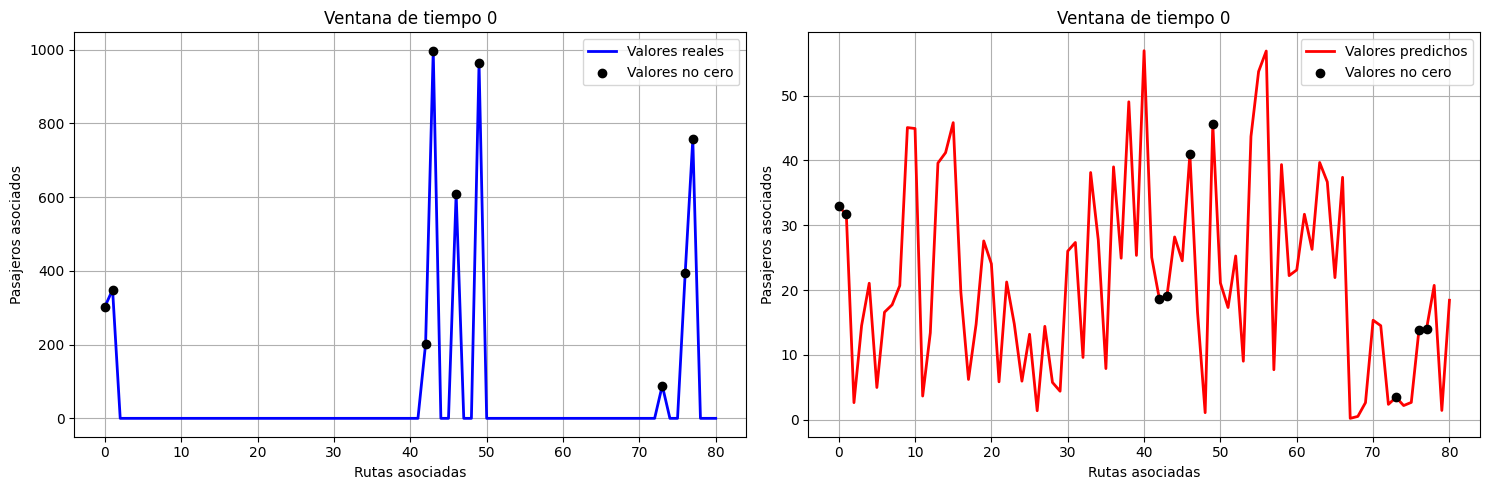

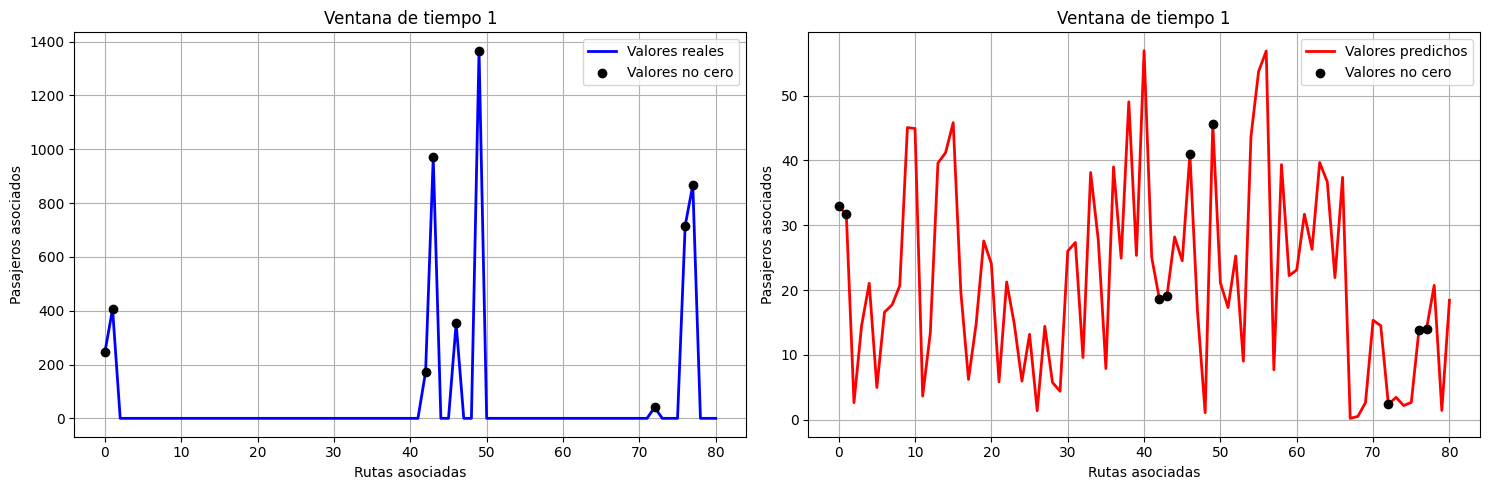

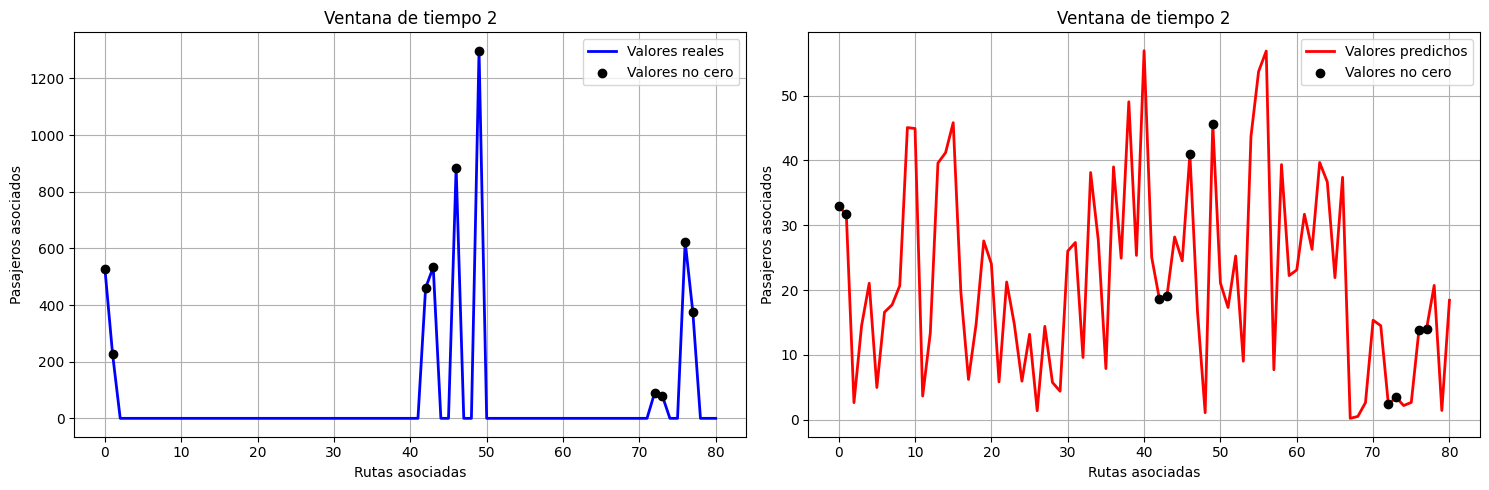

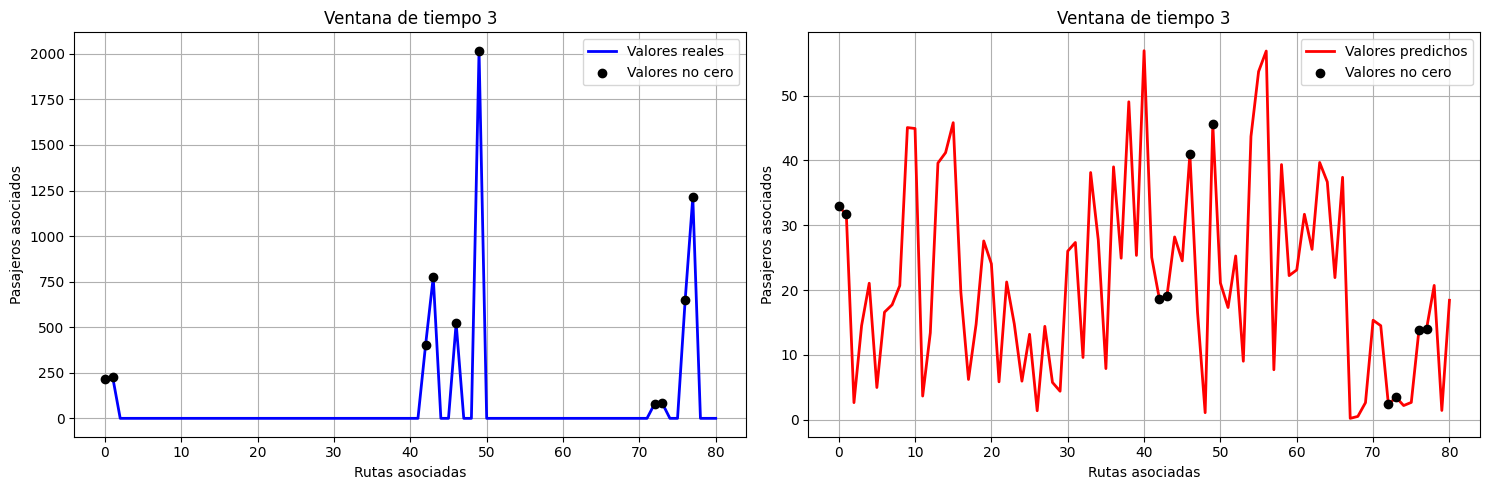

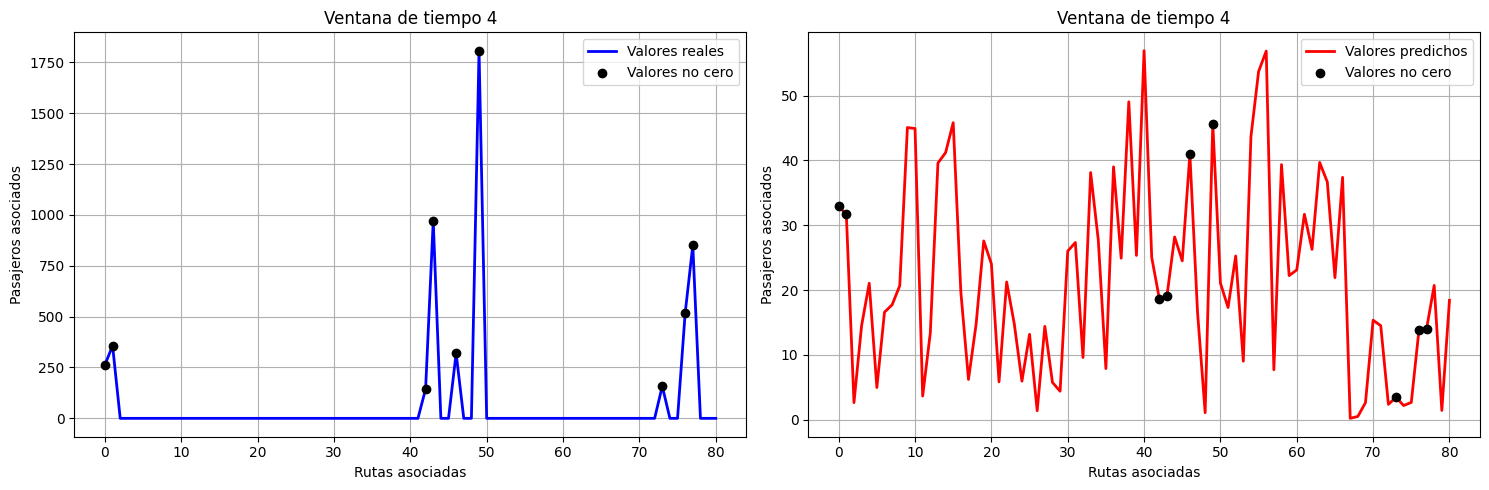

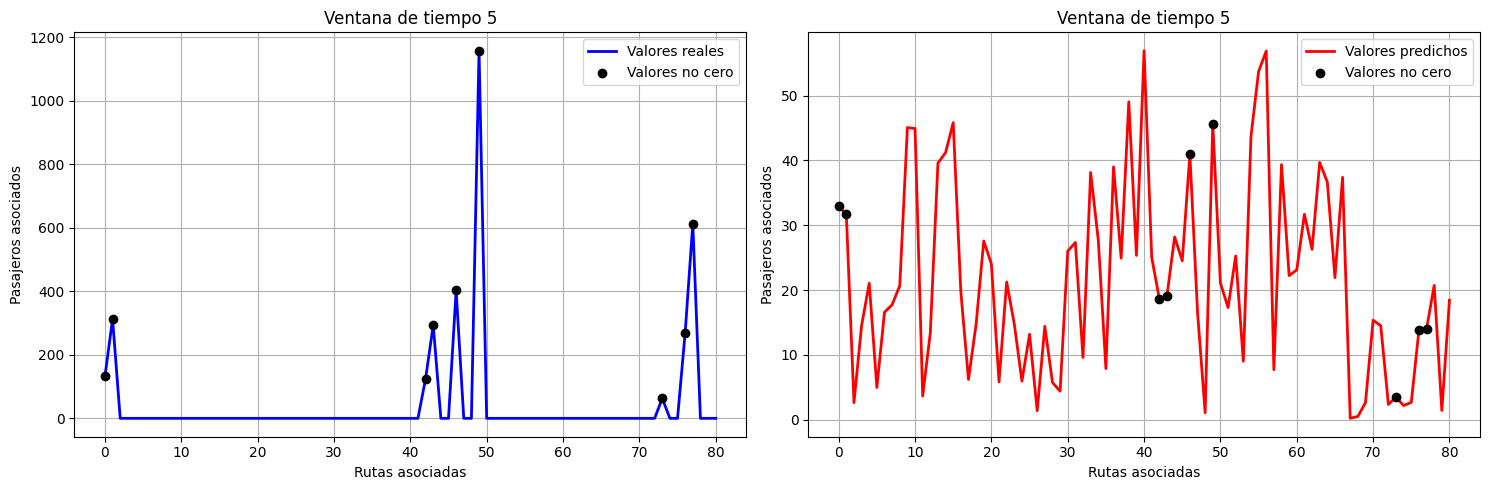

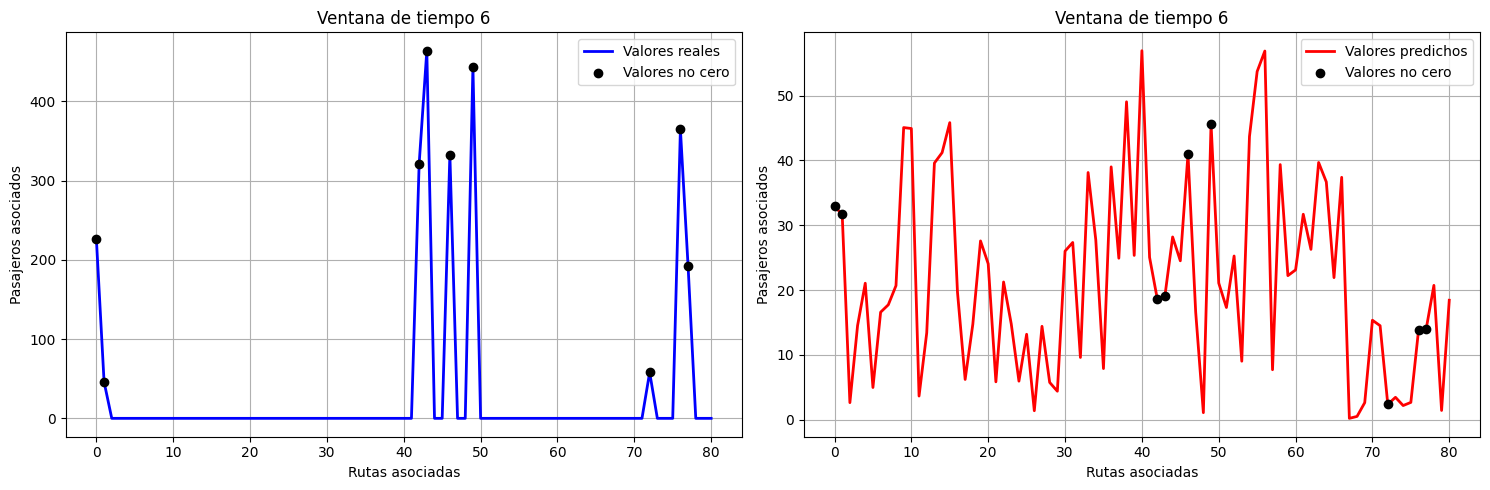

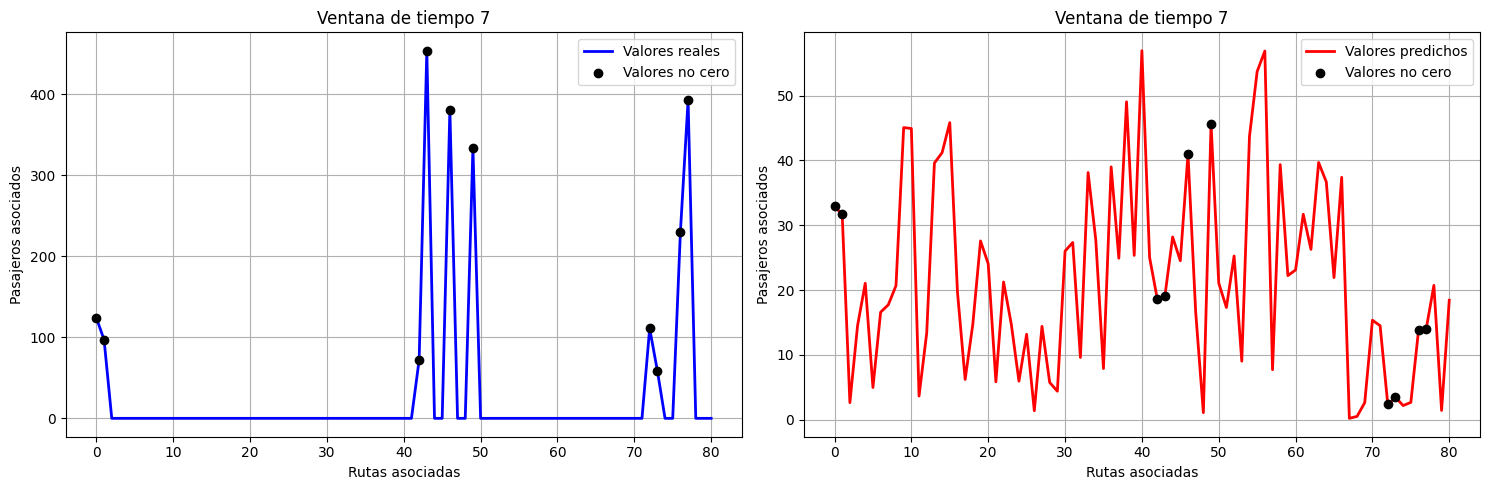

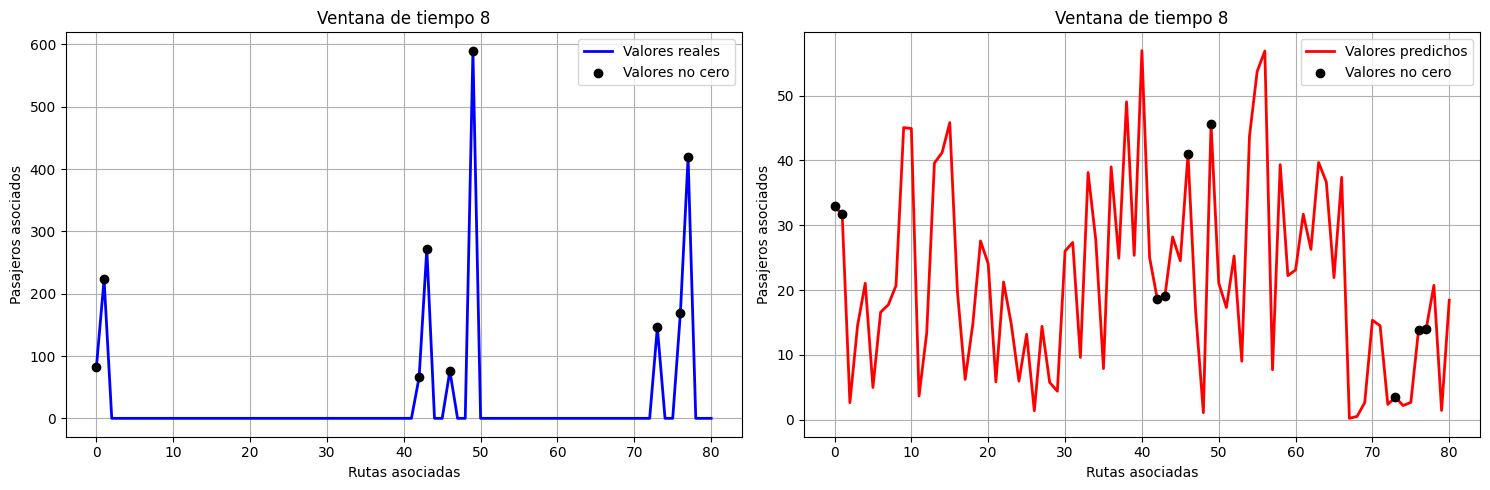

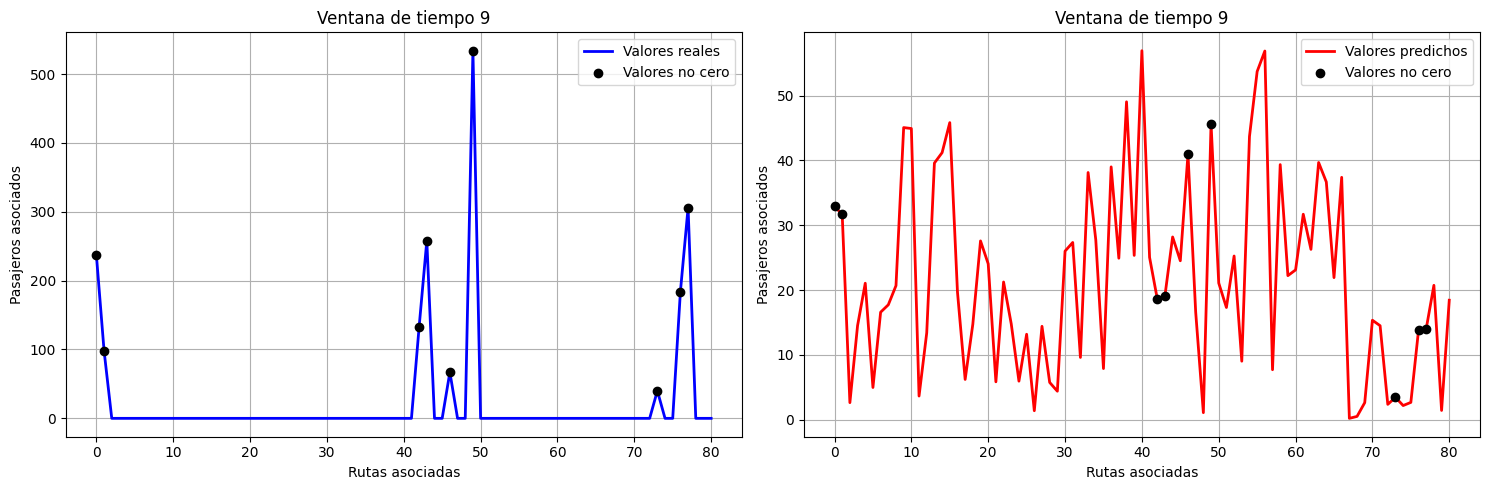

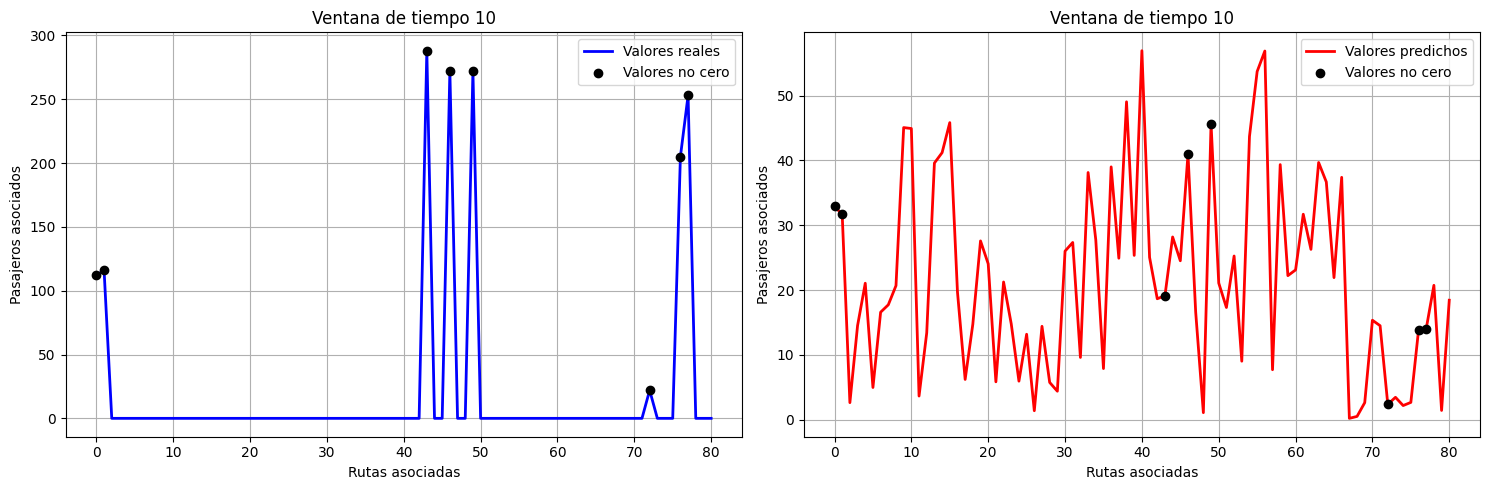

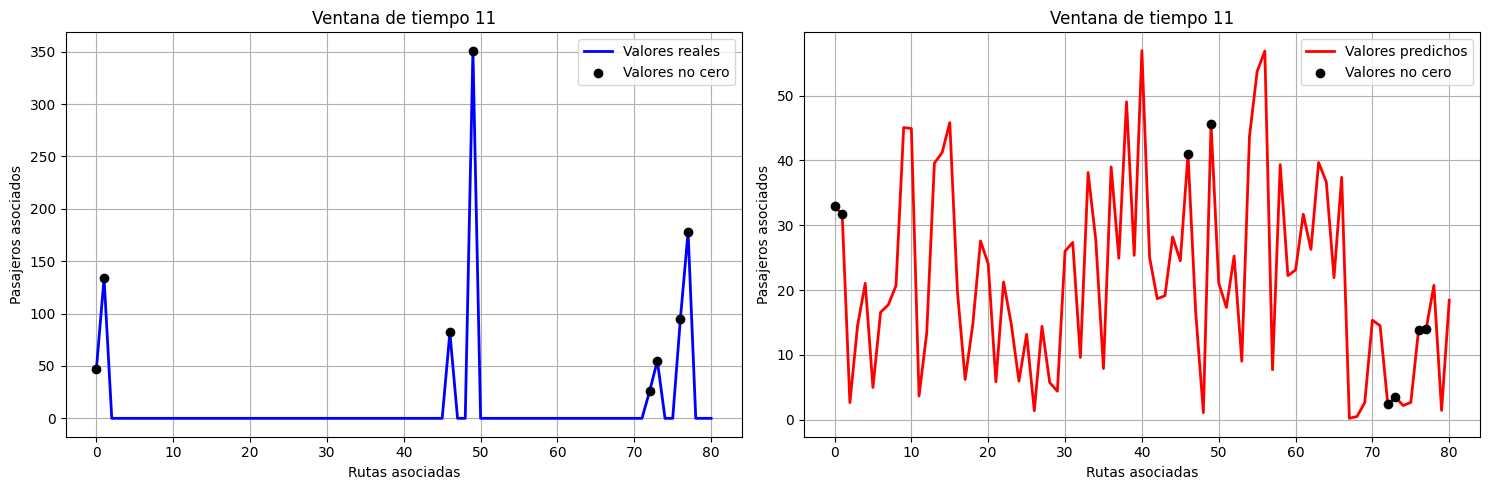

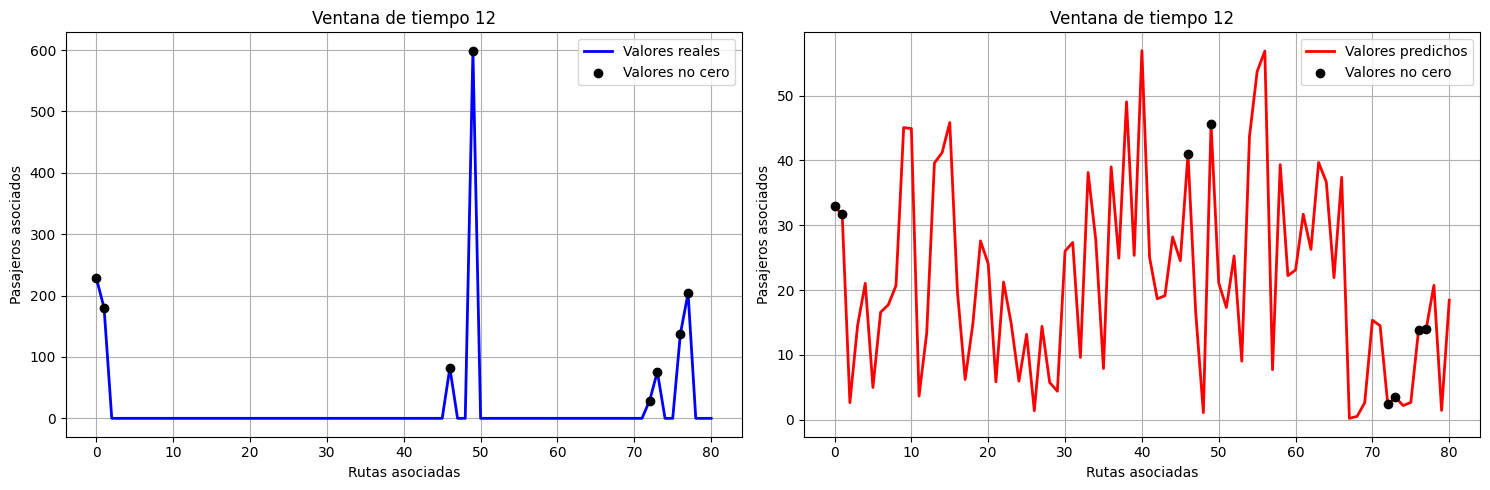

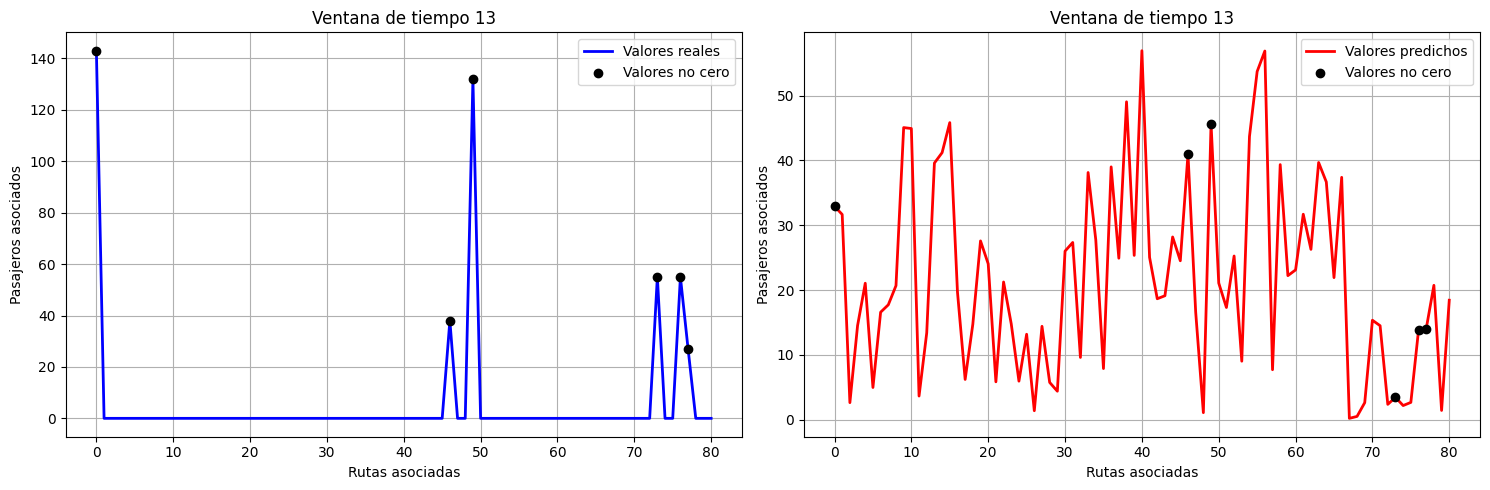

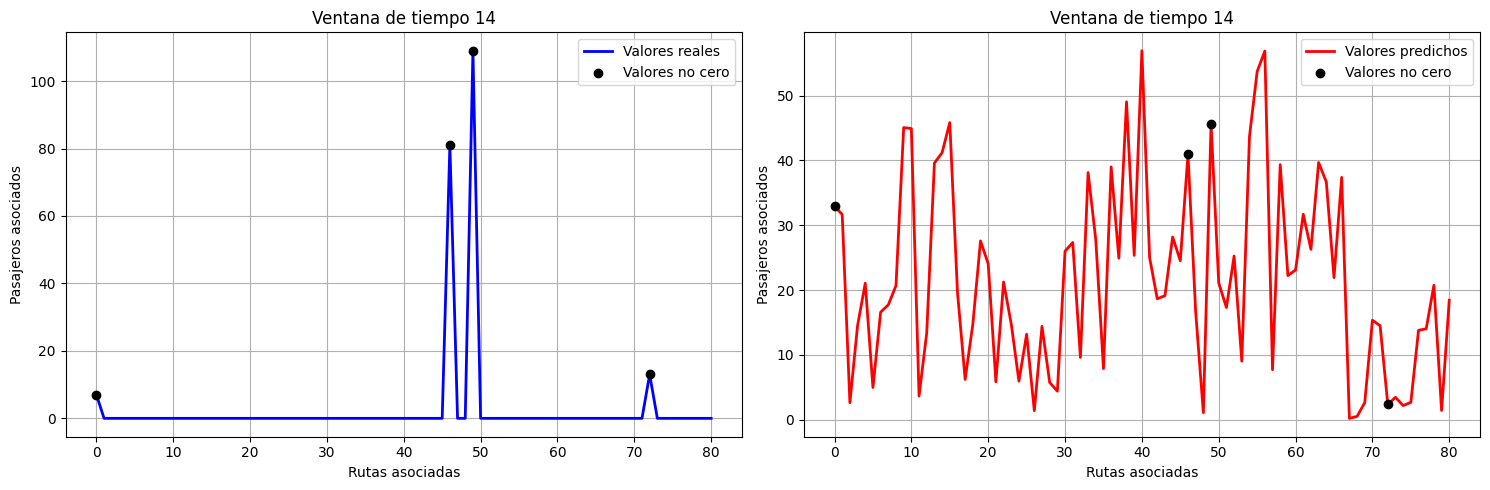

In [49]:

model.load_state_dict(torch.load("Mejor_modelo_stgnn.pth"))
model.eval()

#Obtenemos las últimas 15 ventanas de tiempo
test_size = len(test_dataset)
last_15_indices = list(range(test_size - 15, test_size))
last_15_subset = Subset(test_dataset, last_15_indices)

#Creamos el respectivo dataLoader
last_15_loader = DataLoader(last_15_subset, batch_size=15, shuffle=False)

#Movemos los valores para volver a la escala original al mismo device del modelo
output_min = output_min.to(device)
output_max = output_max.to(device)

predictions_original = []
true_values_original = []

with torch.no_grad():
  for x, A, y in last_15_loader:
    x, A, y = x.to(device), A.to(device), y.to(device)

    #Predicciones normalizadas
    y_pred_normalized = model(x, A)

    #Devolver a escala original
    y_pred_original = y_pred_normalized * (output_max - output_min) + output_min
    y_original = y * (output_max - output_min) + output_min

    predictions_original.append(y_pred_original.cpu())
    true_values_original.append(y_original.cpu())

#Concatenamos la prediccion
predictions_original = torch.cat(predictions_original, dim=0)  #(15, 146, 1, 81)
true_values_original = torch.cat(true_values_original, dim=0)  #(15, 146, 1, 81)


#Almacenamos información, UN corresponde al nodo 141
predictions_original_UN = predictions_original[:, 141, :, :].reshape((15, -1))
true_values_original_UN = true_values_original[:, 141, :, :].reshape((15, -1))

for time_step in range(15):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # Plot valores reales
  ax1.plot(true_values_original_UN[time_step], 'b-', label='Valores reales', linewidth=2)

  #Valores no nulos reales
  non_zero_indices = np.where(true_values_original_UN[time_step] != 0)[0]
  ax1.scatter(non_zero_indices, true_values_original_UN[time_step][non_zero_indices],
              color='black', label='Valores no cero', zorder=5)

  ax1.set_title(f'Ventana de tiempo {time_step}')
  ax1.set_xlabel('Rutas asociadas')
  ax1.set_ylabel('Pasajeros asociados')
  ax1.grid(True)
  ax1.legend()

  # Plot valores predichos
  ax2.plot(predictions_original_UN[time_step], 'r-', label='Valores predichos', linewidth=2)

  #Valores no nulos predichos
  ax2.scatter(non_zero_indices, predictions_original_UN[time_step][non_zero_indices],
              color='black', label='Valores no cero', zorder=5)

  ax2.set_title(f'Ventana de tiempo {time_step}')
  ax2.set_xlabel('Rutas asociadas')
  ax2.set_ylabel('Pasajeros asociados')
  ax2.grid(True)
  ax2.legend()

  plt.tight_layout()
  plt.show()
  plt.close()